# Visualization
Some preliminary visualizations of our simulated ARs.

In [1]:
import os
import copy
import subprocess

import numpy as np
from scipy.ndimage.filters import gaussian_filter
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import LogFormatter
import seaborn as sns
import astropy.units as u
import astropy.constants as const
from sunpy.map import GenericMap,Map,MapCube

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.util import EISCube

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Testing Temperature and LOS Velocity Maps

Load field

In [138]:
root_dir = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_low_frequency/'

In [139]:
field = synthesizAR.Skeleton.restore(os.path.join(root_dir,'field_checkpoint/'))

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-05-17 16:15:51,554 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-05-17 16:15:51,556 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-05-17 16:15:51,567 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-05-17 16:15:51,568 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-05-17 16:15:51,569 Parameters: cosmological_simulation   = 0.0


Initialize instruments.

In [140]:
aia = InstrumentSDOAIA([0,2e4]*u.s)
eis = InstrumentHinodeEIS([0,2e4]*u.s)

Initialize observer object.

In [141]:
observer = synthesizAR.Observer(field,[aia,eis],ds=field._convert_angle_to_length(0.4*u.arcsec))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [142]:
observer.build_detector_files(root_dir)

Look at the LOS velocity and temperature maps.

In [143]:
temperature_map = observer.make_temperature_map(5000*u.s,eis)

Try applying a gaussian filter.

In [144]:
filtered_temperature_map = GenericMap(
    gaussian_filter(temperature_map.data,aia.channels[0]['gaussian_width'].value),
    temperature_map.meta
)
filtered_temperature_map.plot_settings.update(temperature_map.plot_settings)

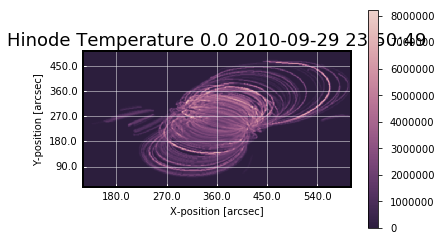

In [145]:
fig = plt.figure()
ax = fig.gca(projection=filtered_temperature_map)
im = filtered_temperature_map.plot(axes=ax)
fig.colorbar(im)

In [146]:
los_velocity_map = observer.make_los_velocity_map(5000*u.s,aia)

In [147]:
filtered_los_velocity_map = GenericMap(
    gaussian_filter(los_velocity_map.data,aia.channels[0]['gaussian_width'].value),
    los_velocity_map.meta
)
filtered_los_velocity_map.plot_settings.update(los_velocity_map.plot_settings)

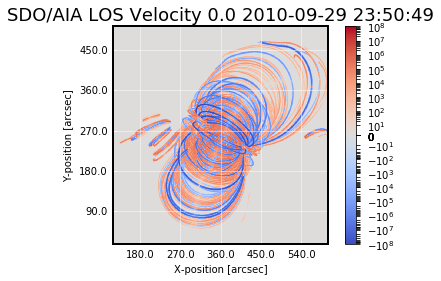

In [148]:
fig = plt.figure()
ax = fig.gca(projection=filtered_los_velocity_map)
im = filtered_los_velocity_map.plot(axes=ax)
fig.colorbar(im)

## "Ground Truth" Emission Measure Distribution
From the interpolated temperature and density information, reconstruct an emission measure distribution in each pixel of the map. We'll do this at AIA resolution.


In [153]:
em_cube = observer.make_emission_measure_map(8e3*u.s,aia,
                                             temperature_bin_edges=10.**(np.arange(5.5,7.5,0.1))*u.K,
                                             plot_settings={'cmap': matplotlib.cm.get_cmap('viridis'),
                                                            'norm': matplotlib.colors.SymLogNorm(1, vmin=1e25, vmax=1e29)})

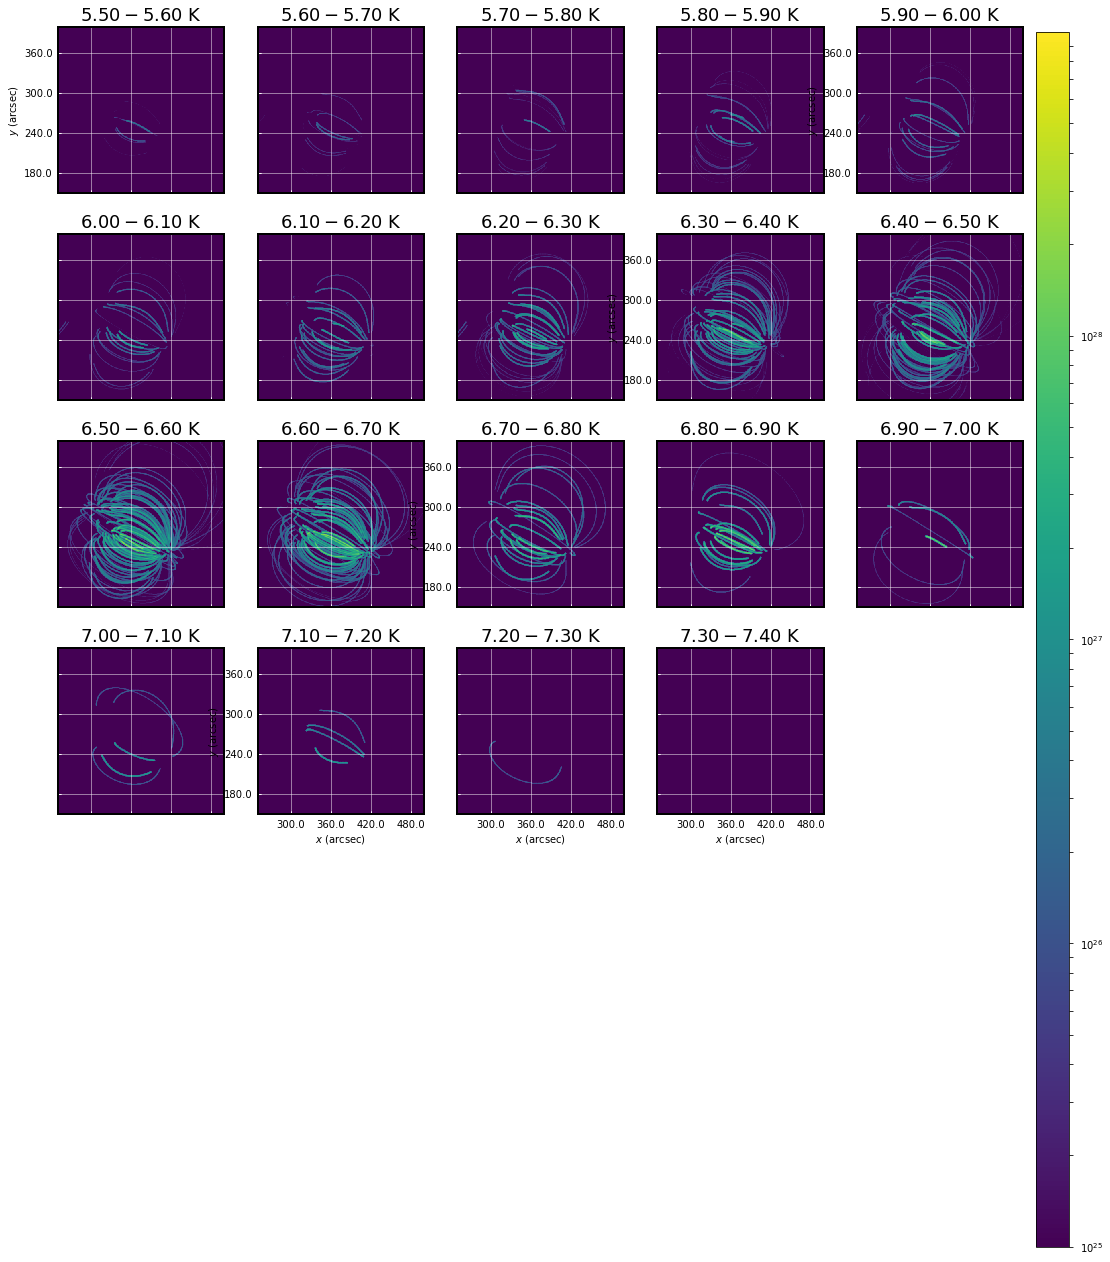

In [157]:
fig = plt.figure(figsize=(18,22.5))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                 )
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<16:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%4==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
#pow_ticks = [i+21 for i in range(10)]
cbar = fig.colorbar(im,
                    #ticks=10.**np.array(pow_ticks),
                    cax=cax,
                    #format=LogFormatter(10,labelOnlyBase=False)
                   )
#cbar.set_ticklabels([r'$10^{{{}}}$'.format(t) for t in pow_ticks],update_ticks=True)
#fig.suptitle(r'Emission Measure, $\mathrm{EM}(T)$ ($\mathrm{cm}^{-5}$)')

It would be interesting to make a movie of these emission measures as a function of time for all of the heating frequencies. It would also be interesting to come up with a way to easily compare the 

Should subclass MapCube and create a custom container for emission measure distributions. Methods could include:
* total emission measure distribution
* calculate EM slope per pixel 
* return 1D EM distribution based on a submap or pixel selection

This would also be a useful container for emission measure distributions derived using other methods, e.g. inversion techniques.

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


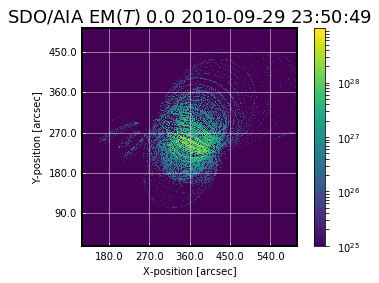

In [129]:
em_cube.total_emission.peek()

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


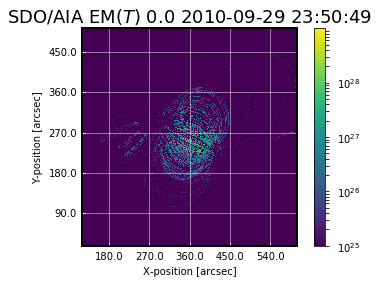

In [130]:
em_cube[0:10].total_emission.peek()

In [131]:
t1d,em1d = em_cube.get_1d_distribution(u.Quantity([300,500],u.pixel),u.Quantity([350,450],u.pixel))

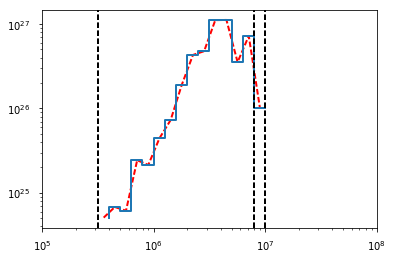

In [137]:
plt.plot((t1d[:-1]+t1d[1:])/2.,em1d,'--r')
plt.step(t1d[1:],(em1d.value),where='pre')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e5,1e8])
#plt.ylim([5e24,3e27])
plt.axvline(x=em_cube.temperature_bin_edges[0].value,color='k',ls='--')
plt.axvline(x=em_cube.temperature_bin_edges[-1].value,color='k',ls='--')
plt.axvline(x=em_cube.temperature_bin_edges[-2].value,color='k',ls='--')

## AIA Observations
Plot some of the AIA observations for the various channels for the three different frequencies we looked at.

In [ ]:
fn_template = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_{freq}_frequency/SDO_AIA/{channel}/map_t{time:06d}.fits'

### Low Frequency Heating

In [ ]:
fig = plt.figure(figsize=(16,9))
for i,channel in enumerate(aia.channels):
    tmp = Map(fn_template.format(freq='low',channel=channel['name'],time=750))
    ax = fig.add_subplot(2,3,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  norm=matplotlib.colors.SymLogNorm(1e-50,vmin=0.1,vmax=1000),
                  annotate=True,
                  title=False
                 )

### Intermediate Frequency Heating

In [ ]:
fig = plt.figure(figsize=(16,9))
for i,channel in enumerate(aia.channels):
    tmp = Map(fn_template.format(freq='intermediate',channel=channel['name'],time=750))
    ax = fig.add_subplot(2,3,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  norm=matplotlib.colors.SymLogNorm(1e-50,vmin=0.1,vmax=1000),
                  annotate=True,
                  title=False
                 )

### High Frequency Heating

In [ ]:
fig = plt.figure(figsize=(16,9))
for i,channel in enumerate(aia.channels):
    tmp = Map(fn_template.format(freq='high',channel=channel['name'],time=750))
    ax = fig.add_subplot(2,3,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  norm=matplotlib.colors.SymLogNorm(1e-50,vmin=0.1,vmax=1000),
                  annotate=True,
                  title=False
                 )

## EIS Observations
TBD